# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to use machine learning algorithms to precict the personality type of a person given their written text in English. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from userson [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [2]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from mbti import run_models

# Random Seed for everything
SEED = 53188535

ModuleNotFoundError: No module named 'imblearn'

In [4]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [5]:
mbti_lst = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

In [6]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [7]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [8]:
cafe_df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

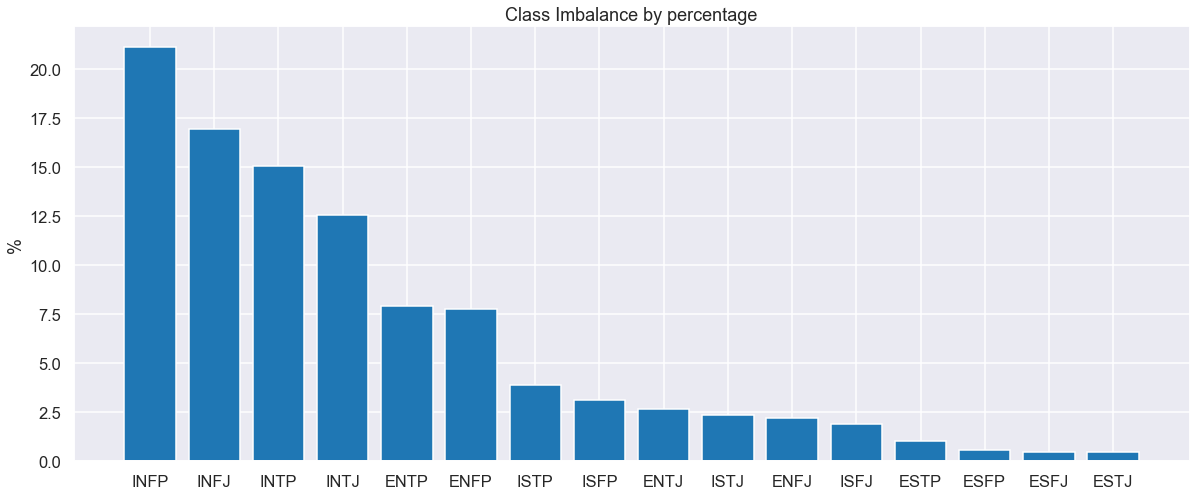

In [9]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [10]:
# looking at a random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can often be quite rude...

>>>>>>>>>>INFJ<<<<<<<<<<
-------------------------
'When you're in public and overhear two people arguing and get way too stressed about something that isn't even your problem; this problem then continues to bother you until some guy walks in with a...|||In addition to needing someone who gets me, I also need to get them. The combination is a challenge  I try to primarily look for someone I get and then test if they get me.|||..uhm... I think this belongs under a different kind of personality page..?|||Yes, I test. What I generally look for is how much space I will be given to be the real me. I have a lot of humour and sarcasm in me, and have always been self concious. Because of this I constantly...|||Are INFJs often clumsy? I can be, especially when being observed!|||Ashamed yes. Me too. Childhood stuff. Someone in close family with manipulating and bad temper. That person destroyed my healthy ways of responding, and I struggle with it to this day. So sometimes I...|||...left the quo

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [11]:
cafe_clean = cafe_df.copy()

In [12]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [13]:
def url_remove(post):
    return re.sub(r'http\S+', '', post)

def pipe_remove(post):
    return re.sub(r'[|]', ' ', post)

def punc_remove(post):
    return re.sub(r'[\'_:]', '', post)

def remove_dig_token(post):
    return [post[i] for i in range(len(post)) if post[i].isalpha()]

def remove_stopwords(post):
    sw = stopwords.words('english')
    # sw.extend(mbti_lst)
    return [post[i] for i in range(len(post)) if post[i] not in sw]

regxx = '(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)|(intp)'
def replace_mbti(post):
    new = re.sub("r" + regxx, "", post)
    return new

def remove_symbols(post):
    encoded_string = post.encode('ascii', 'ignore')
    deconded_string = encoded_string.decode()
    return deconded_string

In [14]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(replace_mbti)

In [15]:
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [16]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(pipe_remove)

In [17]:
# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(url_remove)

In [18]:
# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(punc_remove)

In [19]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(remove_symbols)

In [20]:
# This will create a column of cleaned words that have been tokenized.

pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters

tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer

cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize)

In [21]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_dig_token)

In [22]:
# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_stopwords)

KeyboardInterrupt: 

In [ ]:
# Lemmatizing the words
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lemmatize_text)

In [ ]:
# Joining the tokens together into one long string
def join_tokens(tokens):
    long_string = ' '.join(tokens)
    return long_string

cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(join_tokens) # Creating new column

In [ ]:
corpus = ' '.join(cafe_clean['joined_tokens'])
"".join(sorted(set(corpus.lower()))) 


' abcdefghijklmnopqrstuvwxyz'

The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5378285 total words
--------------------
Each feature in pre-cleaned has on average 1226 words
Each feature in cleaned has on average 620 words
--------------------
Each feature in pre-cleaned  has a median of 1278 words
Each feature has a median of 645 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 916 words
--------------------


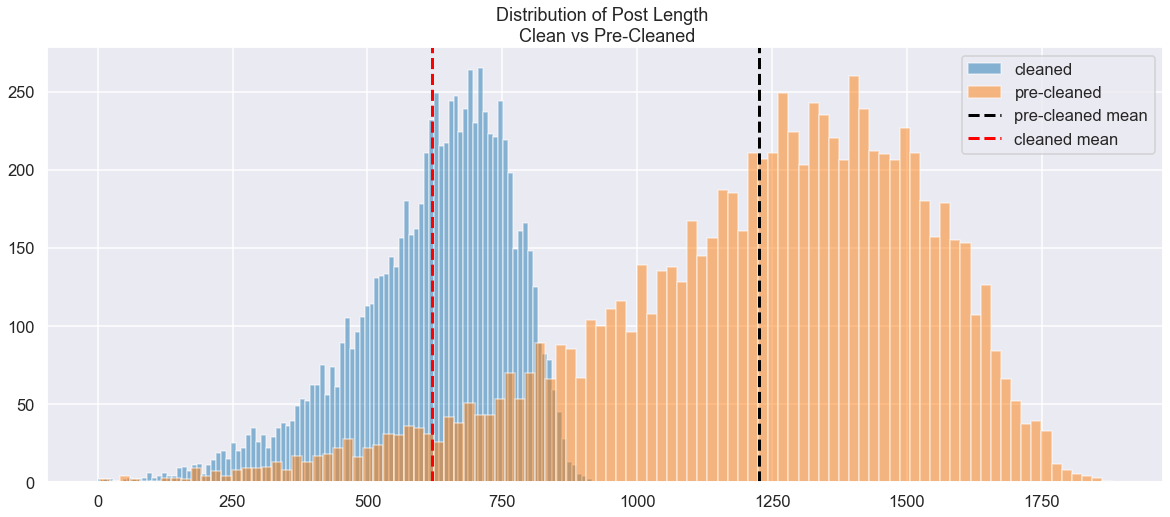

In [ ]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:1000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:1000])

>>>>>>>>>>INFJ<<<<<<<<<<
-------------------------
'INFJ here, 1w2. My favourite used to be Donatello, but as I got older and grew into my personality, I like Leonardo the best, because I relate to him most.  My theory is... Leonardo - INFJ (could...|||One of the reasons I'm interested in becoming a police officer and negotiator for a SWAT team is the chance to show the bad guy empathy, and help him/her change his/her ways.|||Maybe, but then we're both crazy.  I used to try my best to be ambidextrous so my left hand would not feel sad and neglected.  And I always eat in even numbers - four carrots, four cucumber slices,...|||When your therapist tells you that you have a very unique mind...|||59545|||When you have a very strong moral conviction about a certain topic, with a stance that is often misunderstood because it is nor the norm (mine right now has to do with my recently becoming a vegan -...|||I completely understand.  I personally believe human beings (as an animal species) to b

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [ ]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [ ]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


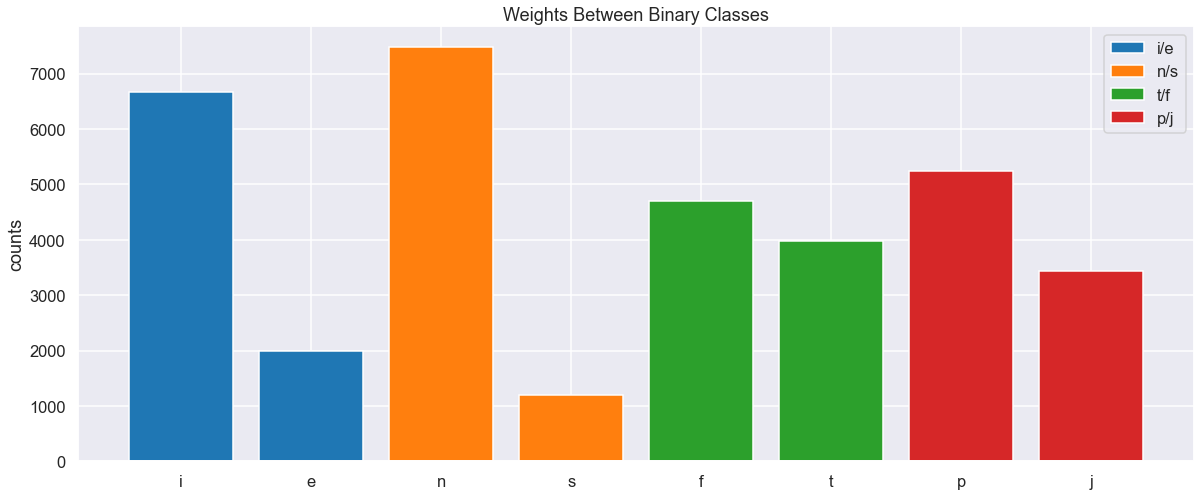

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

In [ ]:
# cafe_clean.to_csv('./data/cafe_clean.csv')

## Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [ ]:
# Baseline
baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

SGDClassifier(class_weight='balanced', random_state=53188535)
MultinomialNB()


In [ ]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
rm = run_models()

In [ ]:
rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Tue Mar  1 14:05:53 2022
Working on SGDClassifier for type @ Tue Mar  1 14:06:03 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for type @ Tue Mar  1 14:06:34 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.3495,0.3407
1,NaiveBayes_type,type,0.2189,0.2144


In [ ]:
rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Tue Mar  1 14:06:38 2022
Working on SGDClassifier for type @ Tue Mar  1 14:06:49 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for type @ Tue Mar  1 14:07:10 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.4222,0.4108
1,NaiveBayes_type,type,0.2115,0.2098


(0.0, 1.0)

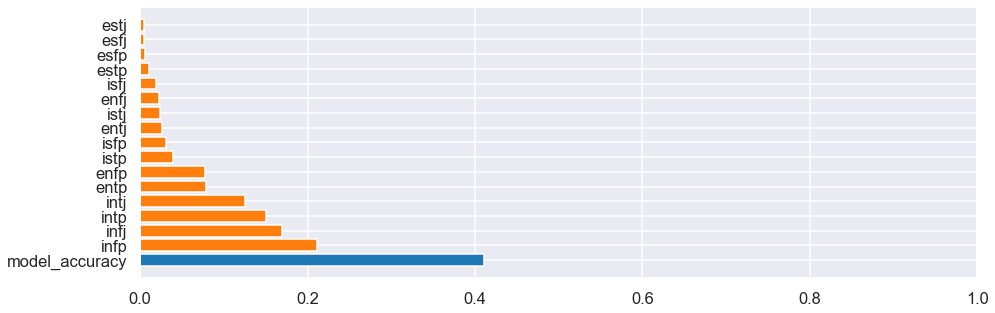

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1)

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 142,  506,  173,  514,   32,   36,   29,   67, 1102, 1374,  818,
        978,  125,  203,  154,  253]))
(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]))
Vectorizing....  @ Tue Mar  1 14:07:14 2022
Working on SGDClassifier @ Tue Mar  1 14:07:16 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:07:16 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.1013,0.1143
1,NaiveBayes_type,type,0.1012,0.0452


(0.0, 1.0)

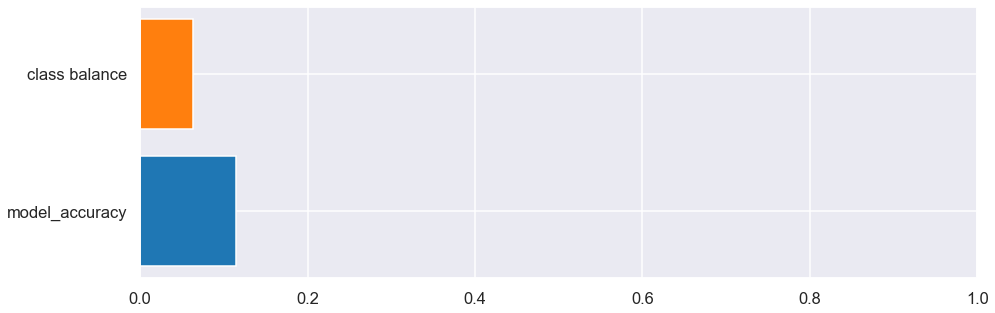

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

i    0.769568
e    0.230432
Name: i/e, dtype: float64
n    0.862017
s    0.137983
Name: n/s, dtype: float64
f    0.541095
t    0.458905
Name: t/f, dtype: float64
p    0.60415
j    0.39585
Name: p/j, dtype: float64


In [ ]:
bin_targets = cafe_clean.columns[-4:]

In [ ]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Tue Mar  1 14:08:47 2022
Working on SGDClassifier for i/e @ Tue Mar  1 14:08:58 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for i/e @ Tue Mar  1 14:09:01 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:09:02 2022
Working on SGDClassifier for n/s @ Tue Mar  1 14:09:12 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for n/s @ Tue Mar  1 14:09:13 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:09:14 2022
Working on SGDClassifier for t/f @ Tue Mar  1 14:09:24 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for t/f @ Tue Mar  1 14:09:27 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:09:28 2022
Working on SGDClassifier for p/j @ Tue Mar  1 14:09:38 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for p/j @ Tue Mar  1 14:09:41 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7805,0.7875
1,NaiveBayes_i/e,i/e,0.7704,0.7672
2,SGDClassifier_n/s,n/s,0.8641,0.8575
3,NaiveBayes_n/s,n/s,0.8644,0.8548
4,SGDClassifier_t/f,t/f,0.8008,0.7981
5,NaiveBayes_t/f,t/f,0.5458,0.5284
6,SGDClassifier_p/j,p/j,0.6771,0.6888
7,NaiveBayes_p/j,p/j,0.6101,0.5864


In [ ]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Tue Mar  1 14:09:42 2022
Working on SGDClassifier for i/e @ Tue Mar  1 14:09:54 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for i/e @ Tue Mar  1 14:09:58 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:09:59 2022
Working on SGDClassifier for n/s @ Tue Mar  1 14:10:09 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for n/s @ Tue Mar  1 14:10:12 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:10:13 2022
Working on SGDClassifier for t/f @ Tue Mar  1 14:10:23 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for t/f @ Tue Mar  1 14:10:26 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Tue Mar  1 14:10:27 2022
Working on SGDClassifier for p/j @ Tue Mar  1 14:10:37 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for p/j @ Tue Mar  1 14:10:40 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.761,0.769
1,NaiveBayes_i/e,i/e,0.7691,0.7672
2,SGDClassifier_n/s,n/s,0.8421,0.8469
3,NaiveBayes_n/s,n/s,0.864,0.8548
4,SGDClassifier_t/f,t/f,0.7759,0.7736
5,NaiveBayes_t/f,t/f,0.6888,0.61
6,SGDClassifier_p/j,p/j,0.6502,0.6584
7,NaiveBayes_p/j,p/j,0.6204,0.5869


In [ ]:
cafe_clean['p/j'].value_counts(normalize=True)

p    0.60415
j    0.39585
Name: p/j, dtype: float64

Accuracy increase from class balance in i/e is: 0.01
Accuracy increase from class balance in n/s is: -0.01
Accuracy increase from class balance in t/f is: 0.25
Accuracy increase from class balance in p/j is: 0.08


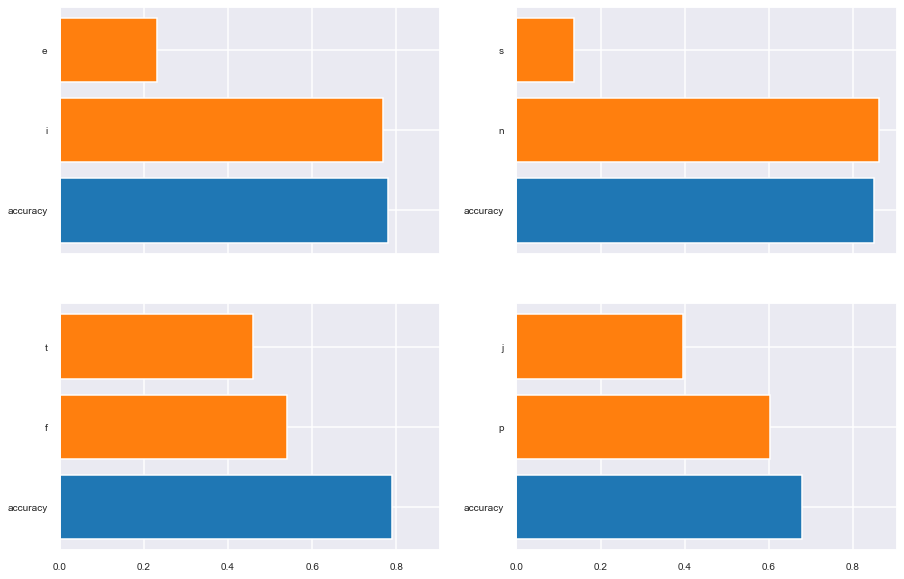

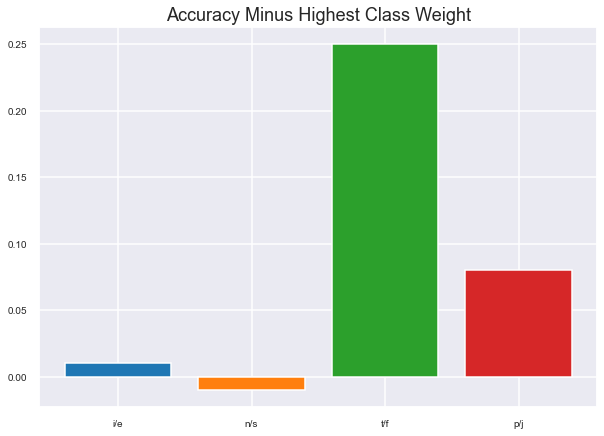

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


In [ ]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

(array(['e', 'i'], dtype=object), array([1499, 5007]))
(array(['e', 'i'], dtype=object), array([1499, 1499]))
Vectorizing....  @ Tue Mar  1 14:10:41 2022
Working on SGDClassifier @ Tue Mar  1 14:10:46 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:10:47 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['n', 's'], dtype=object), array([5608,  898]))
(array(['n', 's'], dtype=object), array([898, 898]))
Vectorizing....  @ Tue Mar  1 14:10:48 2022
Working on SGDClassifier @ Tue Mar  1 14:10:52 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:10:52 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['f', 't'], dtype=object), array([3520, 2986]))
(array(['f', 't'], dtype=object), array([2986, 2986]))
Vectorizing....  @ Tue Mar  1 14:10:52 2022
Working on SGDClassifier @ Tue Mar  1 14:11:01 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:04 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['j', 'p'], dtype=object), array([2575, 3931]))
(array(['j', 'p'], dtype=object), array([2575, 2575]))
Vectorizing....  @ Tue Mar  1 14:11:05 2022
Working on SGDClassifier @ Tue Mar  1 14:11:13 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:15 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6461,0.674
1,NaiveBayes_i/e,i/e,0.6621,0.6662
2,SGDClassifier_n/s,n/s,0.6564,0.7059
3,NaiveBayes_n/s,n/s,0.6809,0.6644
4,SGDClassifier_t/f,t/f,0.7676,0.7847
5,NaiveBayes_t/f,t/f,0.7338,0.7298
6,SGDClassifier_p/j,p/j,0.6369,0.6215
7,NaiveBayes_p/j,p/j,0.6414,0.6381


In [ ]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

(array(['e', 'i'], dtype=object), array([1499, 5007]))
(array(['e', 'i'], dtype=object), array([1499, 1499]))
Vectorizing....  @ Tue Mar  1 14:11:15 2022
Working on SGDClassifier @ Tue Mar  1 14:11:22 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:22 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['n', 's'], dtype=object), array([5608,  898]))
(array(['n', 's'], dtype=object), array([898, 898]))
Vectorizing....  @ Tue Mar  1 14:11:23 2022
Working on SGDClassifier @ Tue Mar  1 14:11:27 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \
/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:27 2022
(array(['f', 't'], dtype=object), array([3520, 2986]))
(array(['f', 't'], dtype=object), array([2986, 2986]))
Vectorizing....  @ Tue Mar  1 14:11:27 2022
Working on SGDClassifier @ Tue Mar  1 14:11:37 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:39 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['j', 'p'], dtype=object), array([2575, 3931]))
(array(['j', 'p'], dtype=object), array([2575, 2575]))
Vectorizing....  @ Tue Mar  1 14:11:40 2022
Working on SGDClassifier @ Tue Mar  1 14:11:49 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Tue Mar  1 14:11:51 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6821,0.6842
1,NaiveBayes_i/e,i/e,0.6761,0.6284
2,SGDClassifier_n/s,n/s,0.6988,0.7165
3,NaiveBayes_n/s,n/s,0.6943,0.7317
4,SGDClassifier_t/f,t/f,0.7925,0.8031
5,NaiveBayes_t/f,t/f,0.6711,0.6874
6,SGDClassifier_p/j,p/j,0.6612,0.6667
7,NaiveBayes_p/j,p/j,0.645,0.6445


Accuracy increase from class balance in i/e is: 0.18
Accuracy increase from class balance in n/s is: 0.23
Accuracy increase from class balance in t/f is: 0.3
Accuracy increase from class balance in p/j is: 0.16


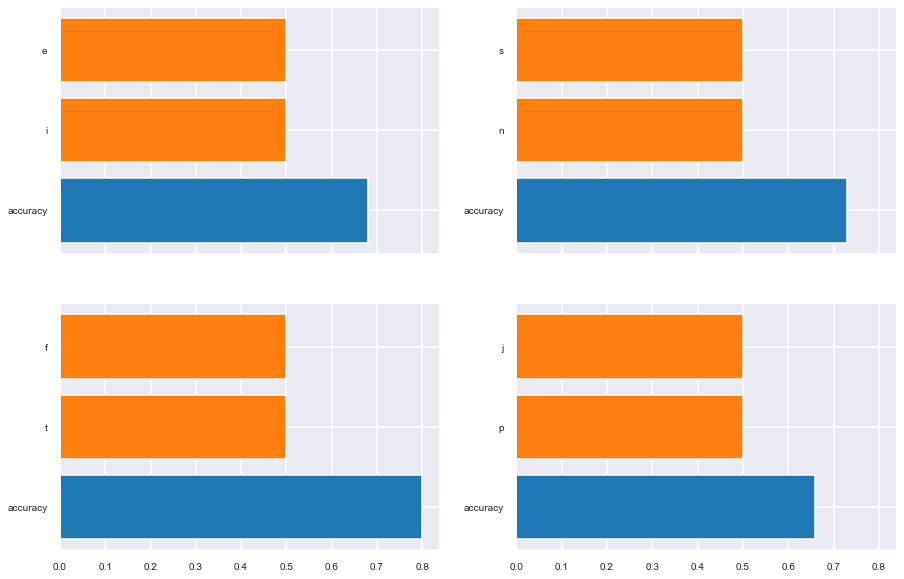

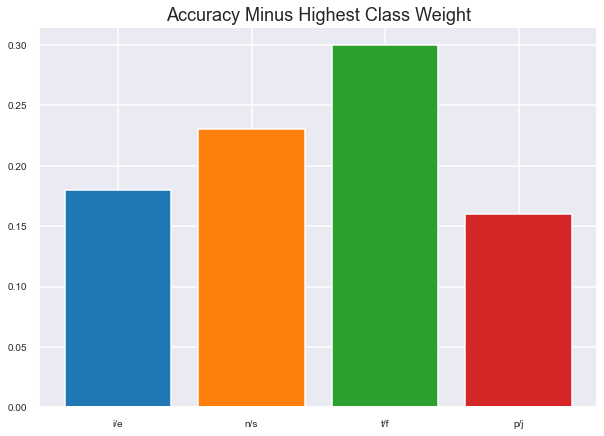

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .68)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .73)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .8)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .66)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


---

## Model Tuning

In [23]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')

In [24]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED))
])

In [27]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

ValueError: np.nan is an invalid document, expected byte or unicode string.

---

### i/e

In [ ]:
cafe_clean['i/e'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'e': .77, 'i': .23}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [ ]:
cafe_clean['n/s'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [ ]:
cafe_clean['t/f'].value_counts(normalize=True)

f    0.541095
t    0.458905
Name: t/f, dtype: float64

              precision    recall  f1-score   support

           f       0.79      0.85      0.82      1150
           t       0.81      0.74      0.78      1019

    accuracy                           0.80      2169
   macro avg       0.80      0.80      0.80      2169
weighted avg       0.80      0.80      0.80      2169



/Users/westonshuken/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


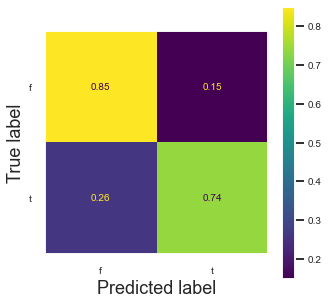

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [ ]:
cafe_clean['p/j'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

In [3]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')
cafe_clean.dropna(inplace=True)

              precision    recall  f1-score   support

           f       0.80      0.83      0.82      1152
           t       0.80      0.76      0.78      1017

    accuracy                           0.80      2169
   macro avg       0.80      0.80      0.80      2169
weighted avg       0.80      0.80      0.80      2169



/Users/westonshuken/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


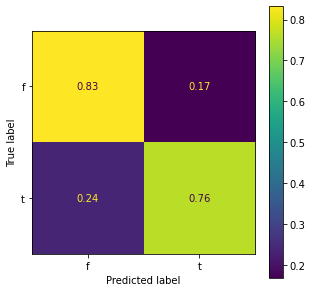

In [7]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

In [33]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

final_model.predict([f_test_sample])

array(['f'], dtype='<U1')

In [34]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

final_model.predict([t_test_sample])

array(['t'], dtype='<U1')

## Further Inspect Thinking vs Feeling

In [118]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

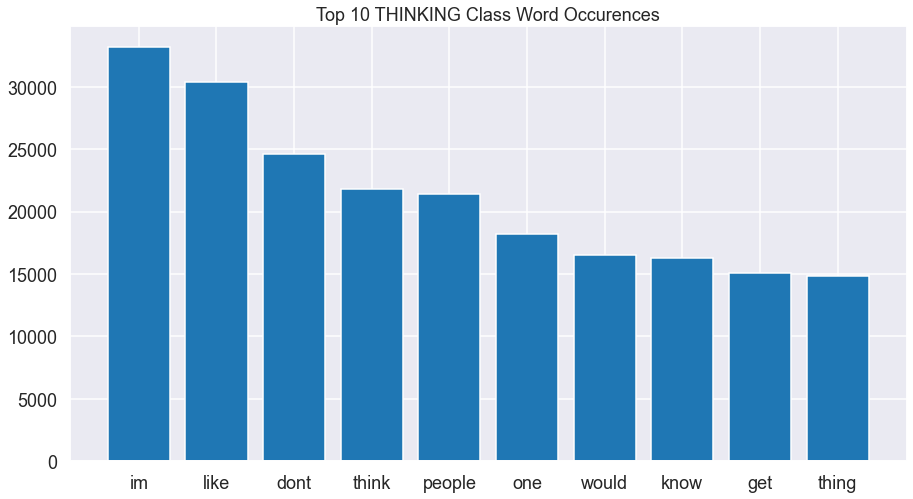

In [119]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

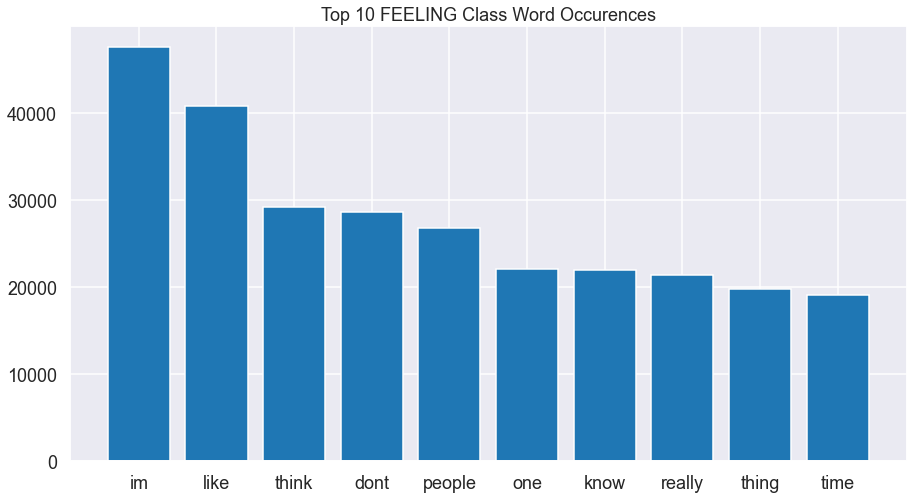

In [120]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

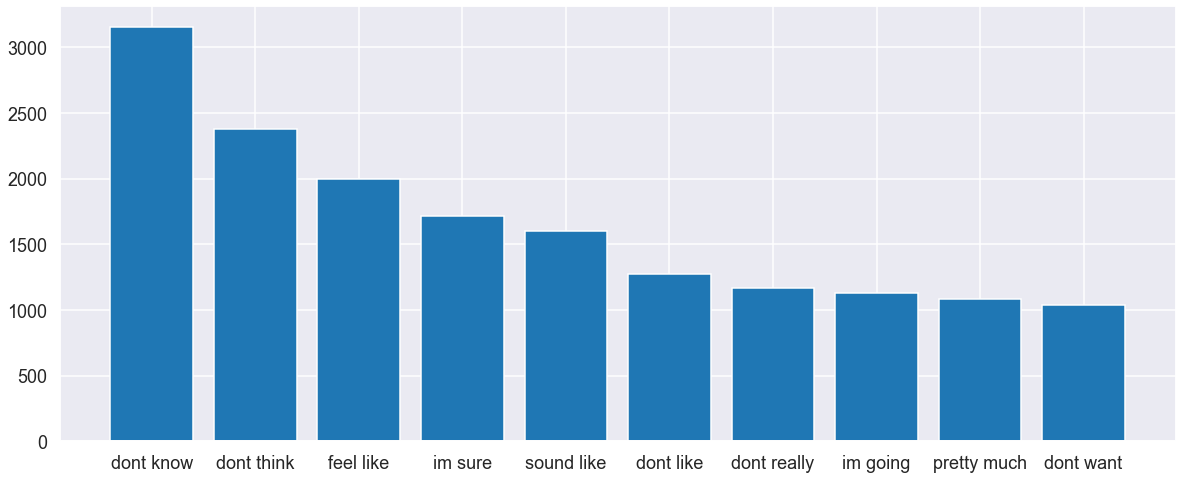

In [121]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

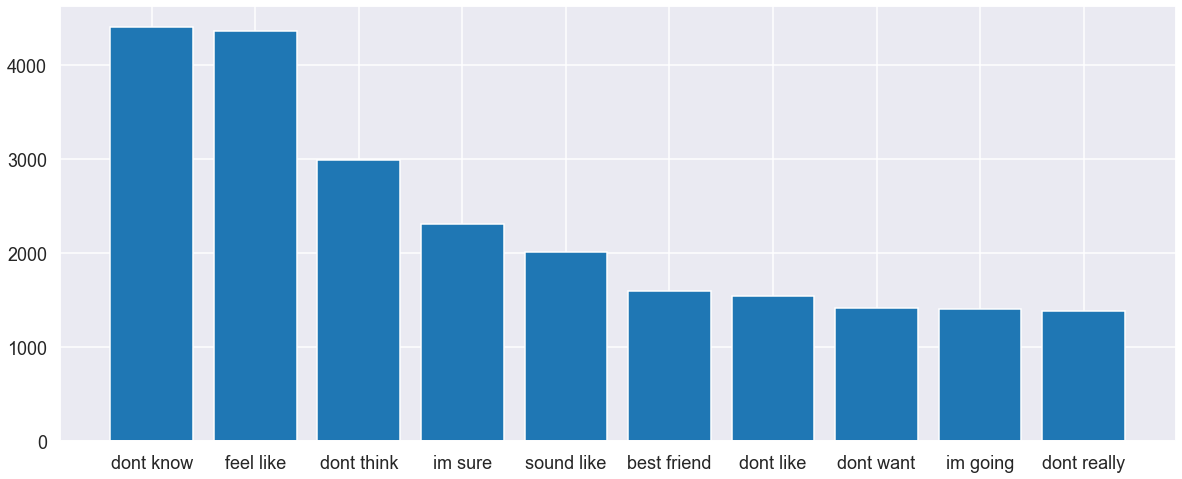

In [122]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

## Thinking vs. Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


### Word Embeddings

In [123]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [127]:
from gensim.models import Word2Vec

---

## 500 Set

In [ ]:
df_500 = pd.read_csv('./data/MBTI 500.csv')

In [ ]:
df_500

In [ ]:
df_500['clean_posts'] = df_500['posts'].apply(replace_mbti)

In [ ]:
df_500['type'] = df_500['type'].str.lower()

In [ ]:
len(df_500)

In [ ]:
df_500 = df_500[df_500['clean_posts'].apply(lambda x: len(x.split())) > 450]

In [ ]:
total_words = df_500['clean_posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

print('-'*20)

ave_post = df_500['clean_posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

print('-'*20)

med_post = df_500['clean_posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

print('-'*20)

min_post = df_500['clean_posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

print('-'*20)

max_post = df_500['clean_posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')


print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(df_500['clean_posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
# Adding Binary Targets
df_500['i/e'] = df_500['type'].map(lambda x: x[0])
df_500['n/s'] = df_500['type'].map(lambda x: x[1])
df_500['t/f'] = df_500['type'].map(lambda x: x[2])
df_500['p/j'] = df_500['type'].map(lambda x: x[3])

In [ ]:
print(df_500['i/e'].value_counts(normalize=True))
print(df_500['n/s'].value_counts(normalize=True))
print(df_500['t/f'].value_counts(normalize=True))
print(df_500['p/j'].value_counts(normalize=True))

In [ ]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [ ]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
rm = run_models()

In [26]:
bin_targets = cafe_clean.columns[-4:]
bin_targets

Index(['i/e', 'n/s', 't/f', 'p/j'], dtype='object')

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500

In [ ]:
print(df_500['i/e'].value_counts(normalize=False))
print(df_500['n/s'].value_counts(normalize=False))
print(df_500['t/f'].value_counts(normalize=False))
print(df_500['p/j'].value_counts(normalize=False))

In [ ]:
rm.run_usampled(df_500, 'clean_posts', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500[df_500.clean_posts.str.match(regxx) == True]

In [ ]:
# final_df = pd.read_pickle('./pickle/finalmodeling_df.pkl')

In [ ]:
# final_df.token_joined.str.match(regxx).sum()

In [ ]:
# final_df['token_joined'] = final_df['token_joined'].apply(replace_mbti)

In [ ]:
# final_df = final_df[final_df.token_joined.str.match(regxx) == False]

In [ ]:
# final_df = final_df.reset_index()

In [ ]:
# final_df

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
# print(final_df['i/e'].value_counts(normalize=True))
# print(final_df['n/s'].value_counts(normalize=True))
# print(final_df['t/f'].value_counts(normalize=True))
# print(final_df['p/j'].value_counts(normalize=True))

In [ ]:
# rint = np.random.randint(0, len(final_df))

# print(rint)
# print(final_df['type'].iloc[rint])
# final_df['token_joined'].iloc[rint]

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps